# Ch.13 Statistics
The notebook focuses on some applications of statistics in finance

* Normality test
* Portfolio optimization
* Bayesian statistics
* Machine learning

In [1]:
import math
import numpy as np  
import scipy.stats as scs
import statsmodels.api as sm
from pylab import plt, mpl
import warnings
warnings.filterwarnings('ignore')
print('Matplotlib version: {}'.format(mpl.__version__))
print('NumPy version: {}'.format(np.__version__))

Matplotlib version: 3.8.4
NumPy version: 1.26.4


## Normality test
It is assumed in many theoretical studies in finance that the returns are normally distributed. This normal distribution is also a baseline when other distributions are discussed. The normal distribution is assumed for the stock price in portfolio theory and in the capital asset pricing model. It is also assumed in the efficient market hypothesis and in the Black-Scholes-Merton option pricing model.  

As an example we use the BSM model

$$S_T = S_0 \exp((r - \frac{1}{2}\sigma^2)T + \sigma \sqrt{T}z)$$

We take a number of M=50 samples, one for each time step, of size I=250000 of the simulated BSM process. Every sample contains I stochastic values and at each time step a new value is calculated for each of them, following the BSM equation. We store the samples as rows of an array S where the columns are the time steps. A row represents a time series, that is the evolution, or path, of one single random variable in M time steps. A column represents the I random variables at a particular time step. using only one time series would not be enough to statistically describe the stochastic process under observation. 

In [2]:
def gen_paths(S0, r, sigma, T, M, I):
    ''' Generate Monte Carlo paths for geometric Brownian motion.
    
    Parameters
    ==========
    S0: float
        initial stock/index value
    r: float
        constant short rate
    sigma: float
        constant volatility
    T: float
        final time horizon
    M: int
        number of time steps/intervals
    I: int
        number of paths to be simulated
        
    Returns
    =======
    paths: ndarray, shape (M + 1, I)
        simulated paths given the parameters
    '''
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean()) / rand.std()  
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                         sigma * math.sqrt(dt) * rand)  
    return paths

In [3]:
S0 = 100.  
r = 0.05  
sigma = 0.2  
T = 1.0   
M = 50  
I = 250000  
np.random.seed(1000)

In [4]:
paths = gen_paths(S0, r, sigma, T, M, I)
paths.shape

(51, 250000)

In [5]:
S0 * math.exp(r * T)

105.12710963760242

We plot the paths of a subset of the I BSM processes

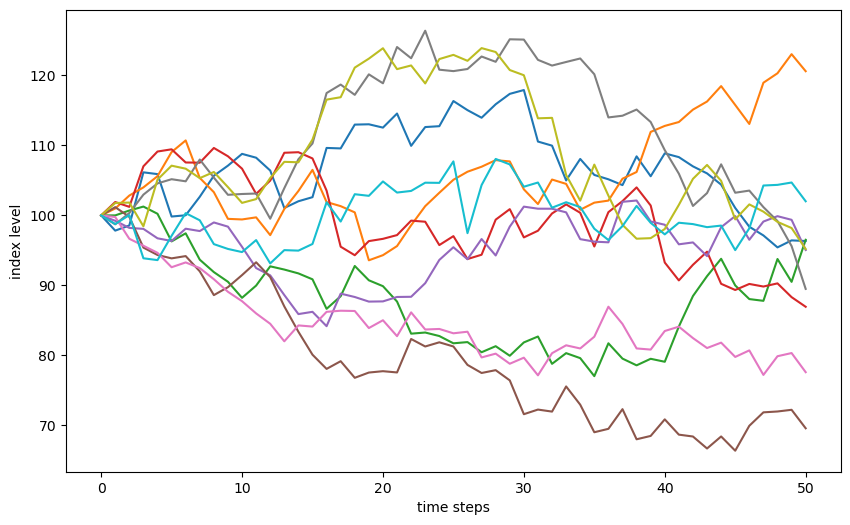

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(paths[:, :10])
plt.xlabel('time steps')
plt.ylabel('index level');

The log-returns are defined as 

$$log \frac{S_t}{S_{t-1}}$$

In [26]:
paths_t1 = paths[:-1]
paths_t1.shape

(50, 250000)

In [25]:
paths_t2 = paths[1:]
paths_t2.shape

(50, 250000)

In [28]:
log_returns = np.log(paths_t2 / paths_t1)
log_returns.shape

(50, 250000)

In [38]:
path0_log_returns = log_returns[:, 0]

In [41]:
def print_statistics(array):
    ''' Prints selected statistics.
        Parameters
        ==========
        array: ndarray
        object to generate statistics on
    '''
    sta = scs.describe(array)
    print('%14s %15s' % ('statistic', 'value'))
    print(30 * '-')
    print('%14s %15.5f' % ('size', sta[0]))
    print('%14s %15.5f' % ('min', sta[1][0]))
    print('%14s %15.5f' % ('max', sta[1][1]))
    print('%14s %15.5f' % ('mean', sta[2]))
    print('%14s %15.5f' % ('std', np.sqrt(sta[3])))
    print('%14s %15.5f' % ('skew', sta[4]))
    print('%14s %15.5f' % ('kurtosis', sta[5]))

We calculate the main moments of the I log-returns of length M

In [44]:
print_statistics(log_returns.flatten())

     statistic           value
------------------------------
          size  12500000.00000
           min        -0.15664
           max         0.15371
          mean         0.00060
           std         0.02828
          skew         0.00055
      kurtosis         0.00085


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(log_returns[:, :].round(4), bins=20)
plt.xlabel('loss')
plt.ylabel('frequency')
#plt.ylim(ymax=175);